In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
runs = pd.read_csv('./presentation/results/runs_2.csv')
runs = runs[~runs['data_path'].isna()]

In [4]:
selected = runs[runs['astromer']=='frozen']

selected['spc'] = selected['data_path'].apply(lambda x: x.split('_')[-1])

/tmp/ipykernel_208588/3768343815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['spc'] = selected['data_path'].apply(lambda x: x.split('_')[-1])


In [7]:
selected_2 = selected[['m_alpha', 'spc', 'dataset', 'model', 'Name', 'probed', 'rs', 'clf_test_f1']]
selected_2 = selected_2[~selected_2['clf_test_f1'].isna()]

## H1: Masking Query and Key tokens does not improve representation when using them for light curve classification

In [8]:
selected_3 = selected_2[selected_2['model'].astype('str').str.contains('bugstromer')]

summary_mean = selected_3.groupby(['dataset', 'm_alpha', 'spc'])['clf_test_f1'].mean().reset_index()
summary_std = selected_3.groupby(['dataset', 'm_alpha', 'spc'])['clf_test_f1'].std().reset_index()
summary = pd.merge(summary_mean, summary_std, on=['m_alpha', 'dataset', 'spc'])
summary['spc'] = summary['spc'].astype(int)

In [9]:
titles = {'alcock':'MACHO', 'atlas':'Atlas'}

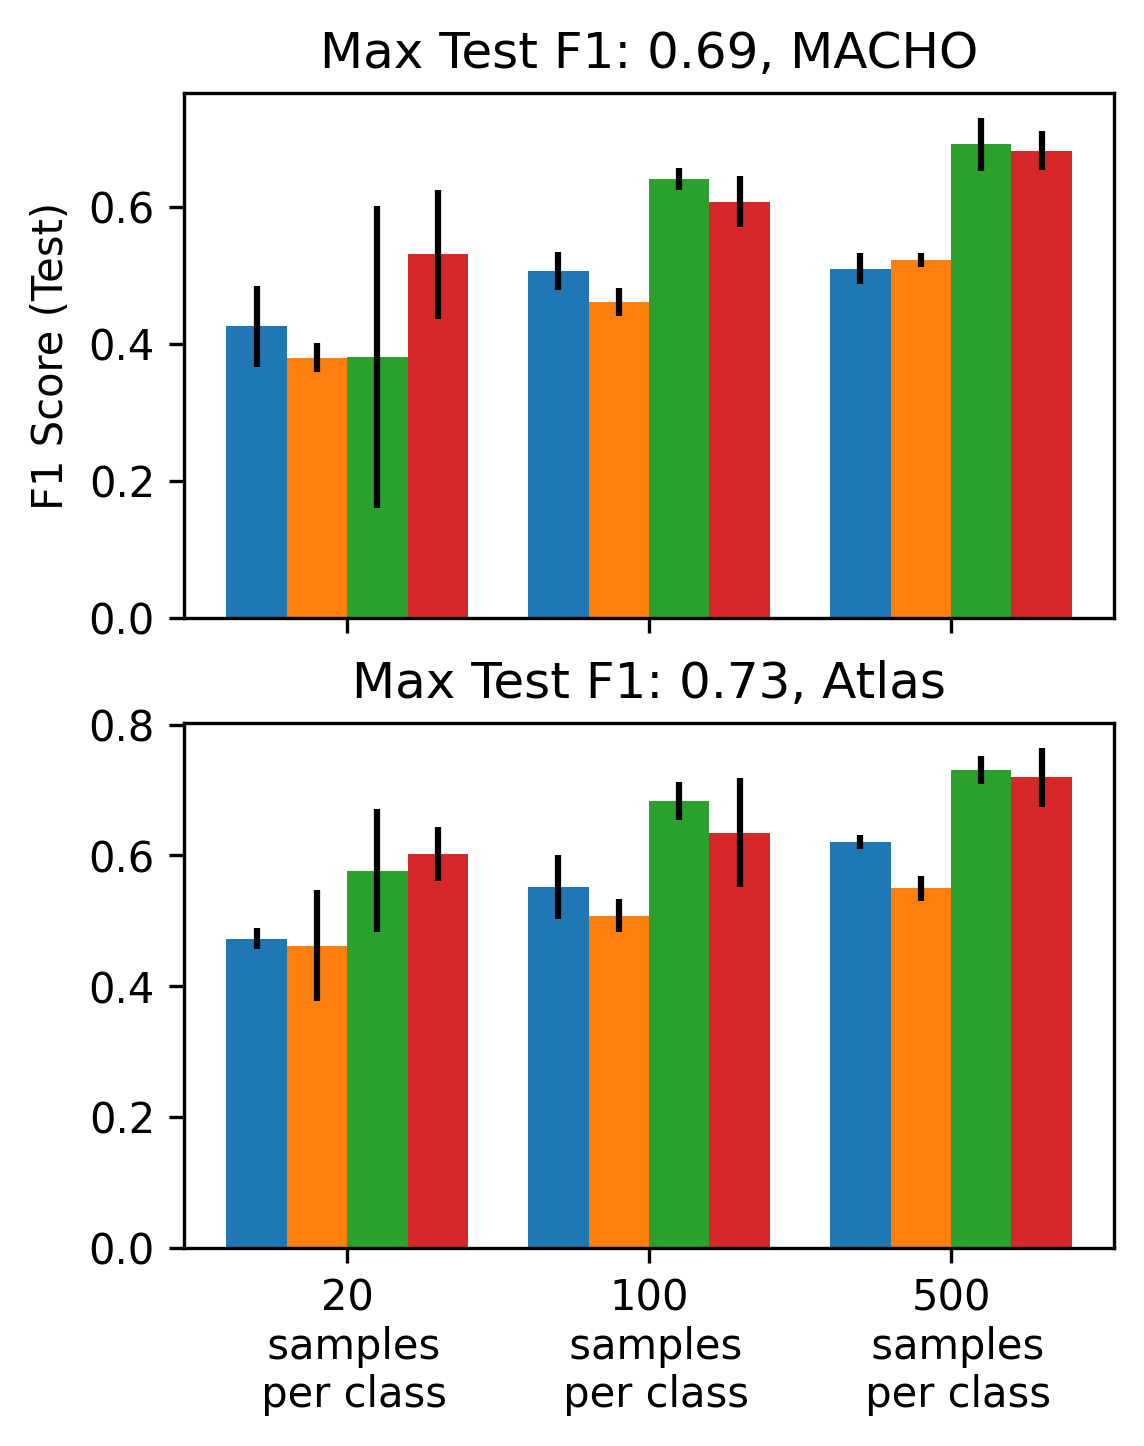

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(4,5), dpi=300, sharex=True)
for i, (dataset, subframe) in enumerate(summary.groupby('dataset')):
    off = 0.
    offsets = []
    max_f1 = subframe['clf_test_f1_x'].max()
    for alph, frame in subframe.groupby('m_alpha'):
        frame = frame.sort_values('spc')
        X_axis = np.arange(frame.shape[0]) + off
        axes[i].bar(X_axis, frame['clf_test_f1_x'], yerr=frame['clf_test_f1_y'], width=0.2, label=alph)
        off+=0.2
        offsets.append(off)
        axes[i].set_xticks(np.linspace(0.3, X_axis[-1]-0.3, 3))
        axes[i].set_xticklabels(['20\n samples\n per class', '100\n samples\n per class', '500\n samples\n per class'])

        axes[i].set_title('Max Test F1: {:.2f}, {}'.format(max_f1, titles[dataset]))
#         axes[i].legend([r'$\alpha = -\infty$ (mask)', 
#                     r'$\alpha = -0.5$', 
#                     r'$\alpha = 0.$ (no mask)', 
#                     r'$\alpha = 1.$ '], bbox_to_anchor=(1., 1.0))
axes[0].set_ylabel('F1 Score (Test)')


plt.show()

## H2: Masking only Query tokens does not improve representation when using them on classification

In [26]:
selected_4 = selected_2[selected_2['model'].astype('str').str.contains('qformat')]

summary_mean = selected_4.groupby(['dataset', 'm_alpha', 'spc'])['clf_test_f1'].mean().reset_index()
summary_std = selected_4.groupby(['dataset', 'm_alpha', 'spc'])['clf_test_f1'].std().reset_index()
summary = pd.merge(summary_mean, summary_std, on=['m_alpha', 'dataset', 'spc'])
summary['spc'] = summary['spc'].astype(int)

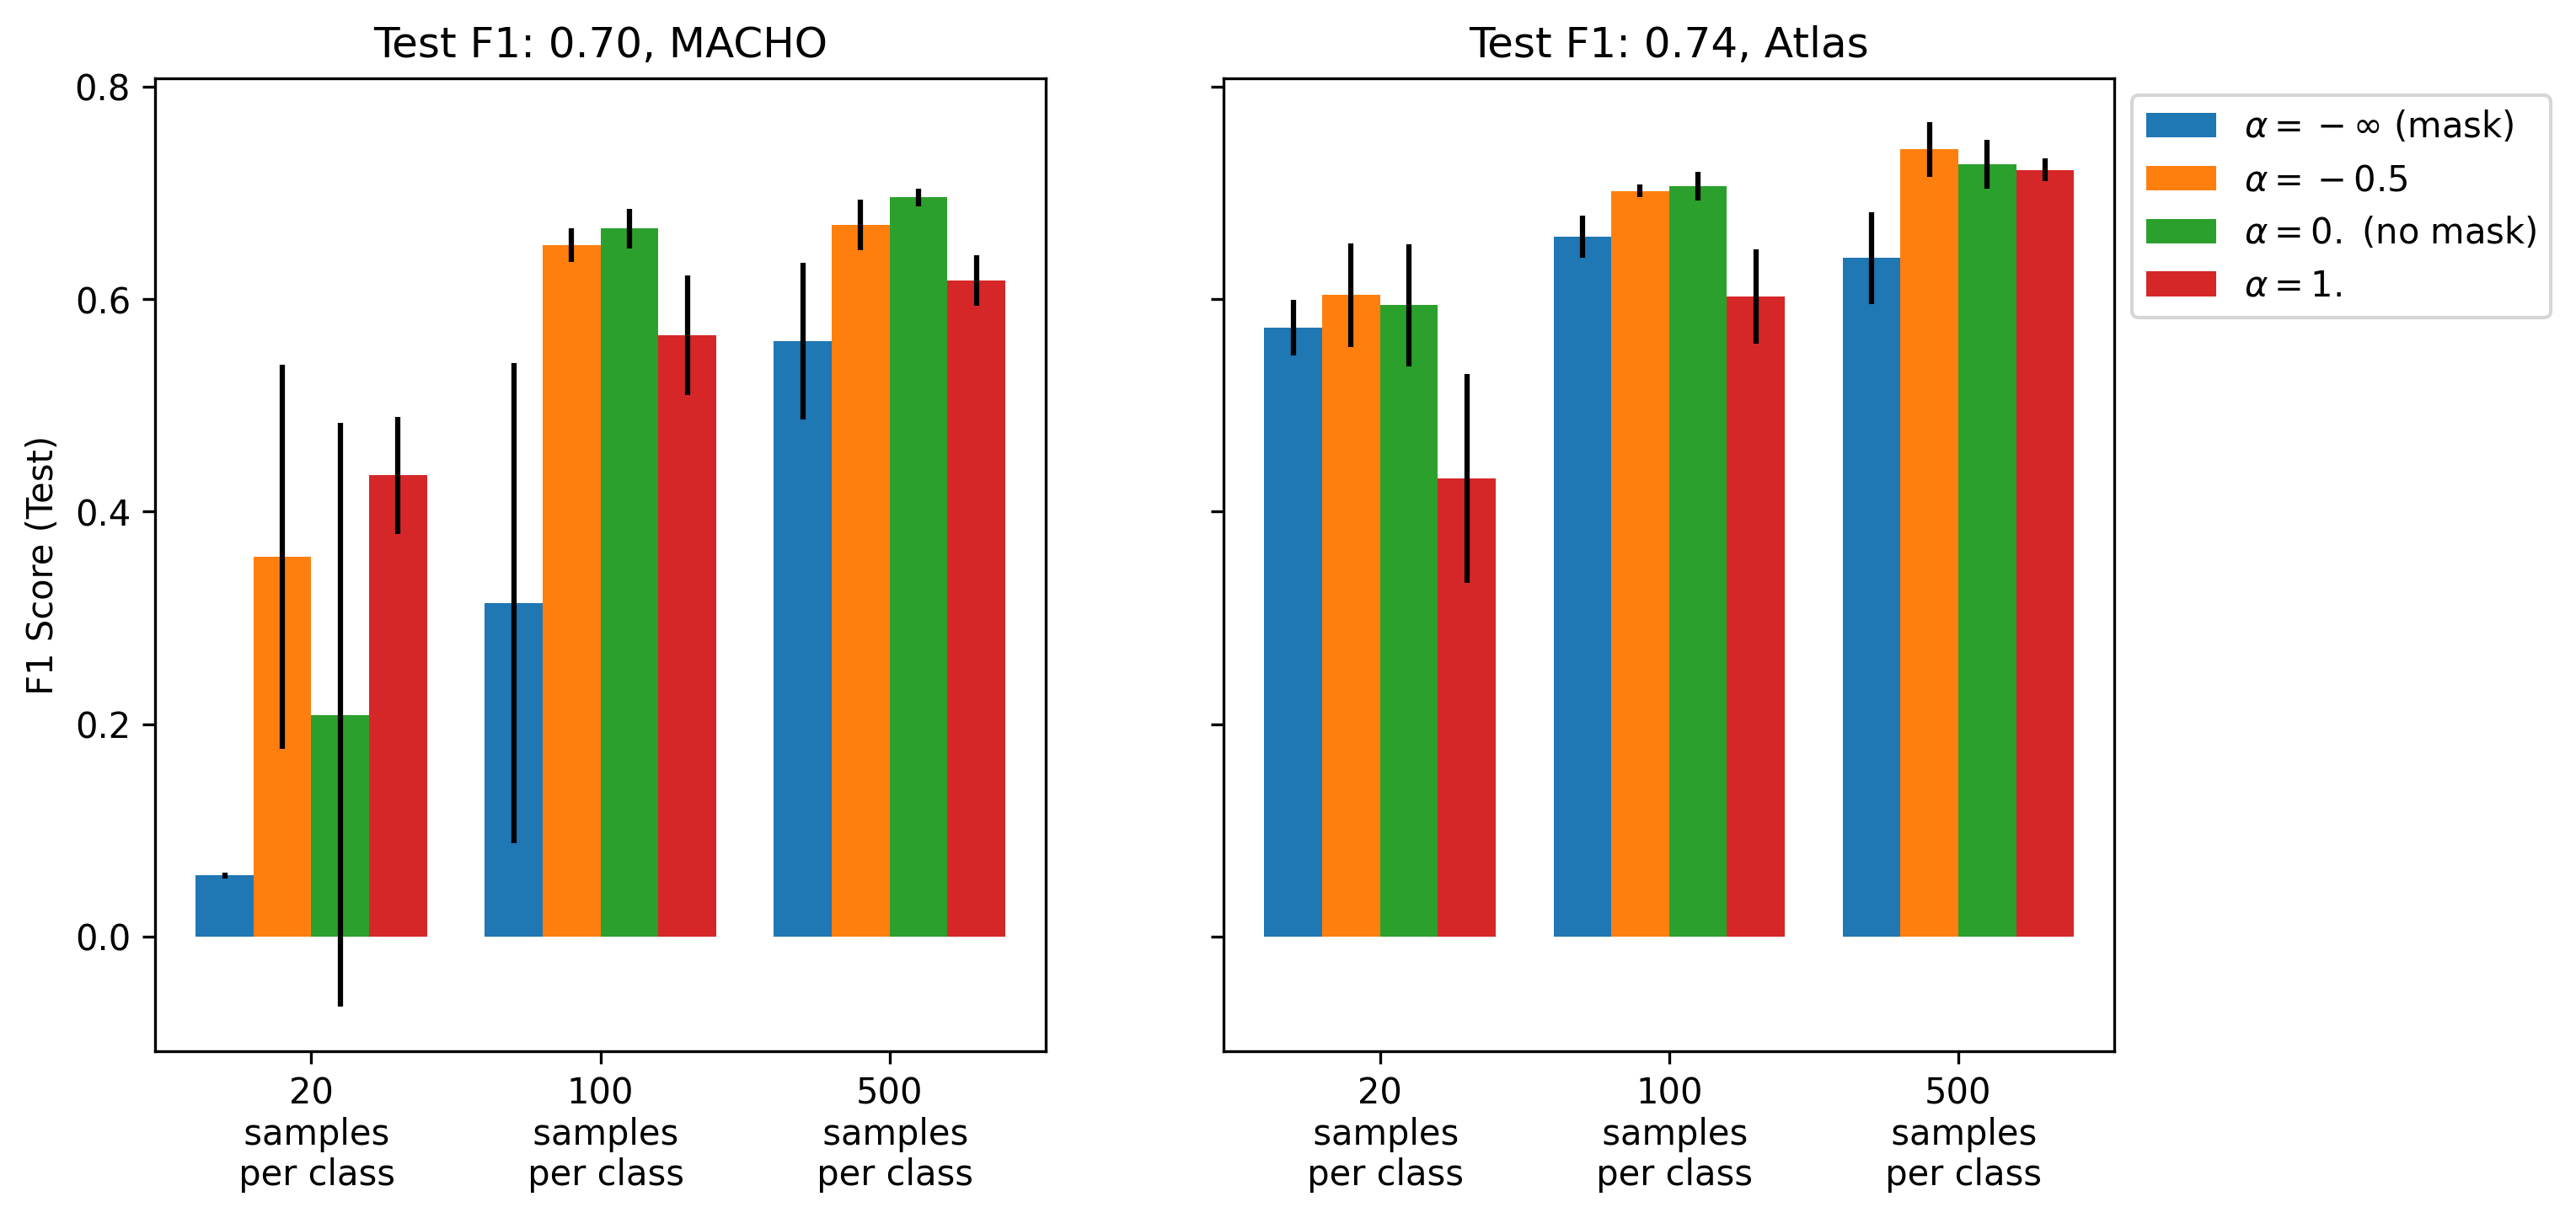

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), dpi=300, sharey=True)
for i, (dataset, subframe) in enumerate(summary.groupby('dataset')):
    off = 0.
    offsets = []
    max_f1 = subframe['clf_test_f1_x'].max()
    for alph, frame in subframe.groupby('m_alpha'):
        frame = frame.sort_values('spc')
        X_axis = np.arange(frame.shape[0]) + off
        axes[i].bar(X_axis, frame['clf_test_f1_x'], yerr=frame['clf_test_f1_y'], width=0.2, label=alph)
        off+=0.2
        offsets.append(off)
        ticksx = np.linspace(0.3, X_axis[-1]-0.3, 3)
        axes[i].set_xticks(ticksx)
        axes[i].set_xticklabels(['20\n samples\n per class', '100\n samples\n per class', '500\n samples\n per class'])
        axes[i].set_title('Test F1: {:.2f}, {}'.format(max_f1, titles[dataset]))

axes[0].set_ylabel('F1 Score (Test)')
axes[-1].legend([r'$\alpha = -\infty$ (mask)', 
            r'$\alpha = -0.5$', 
            r'$\alpha = 0.$ (no mask)', 
            r'$\alpha = 1.$ '], bbox_to_anchor=(1., 1.0))

plt.show()

## H3: The number of masked tokens affect the queality of the representation in terms of F1 Score

In [6]:
r0502 = selected_2[selected_2['model']=='bugstromer_minus_inf']

In [29]:
selected_5 = selected_2[(selected_2['model'].astype('str').str.contains('_inf')) & ~(selected_2['model'].astype('str').str.contains('bugstromer'))]
selected_5 = pd.concat([selected_5, r0502])

In [30]:
summary_mean = selected_5.groupby(['dataset', 'probed', 'spc'])['clf_test_f1'].mean().reset_index()
summary_std = selected_5.groupby(['dataset', 'probed', 'spc'])['clf_test_f1'].std().reset_index()
summary = pd.merge(summary_mean, summary_std, on=['probed', 'dataset', 'spc'])
summary['spc'] = summary['spc'].astype(int)

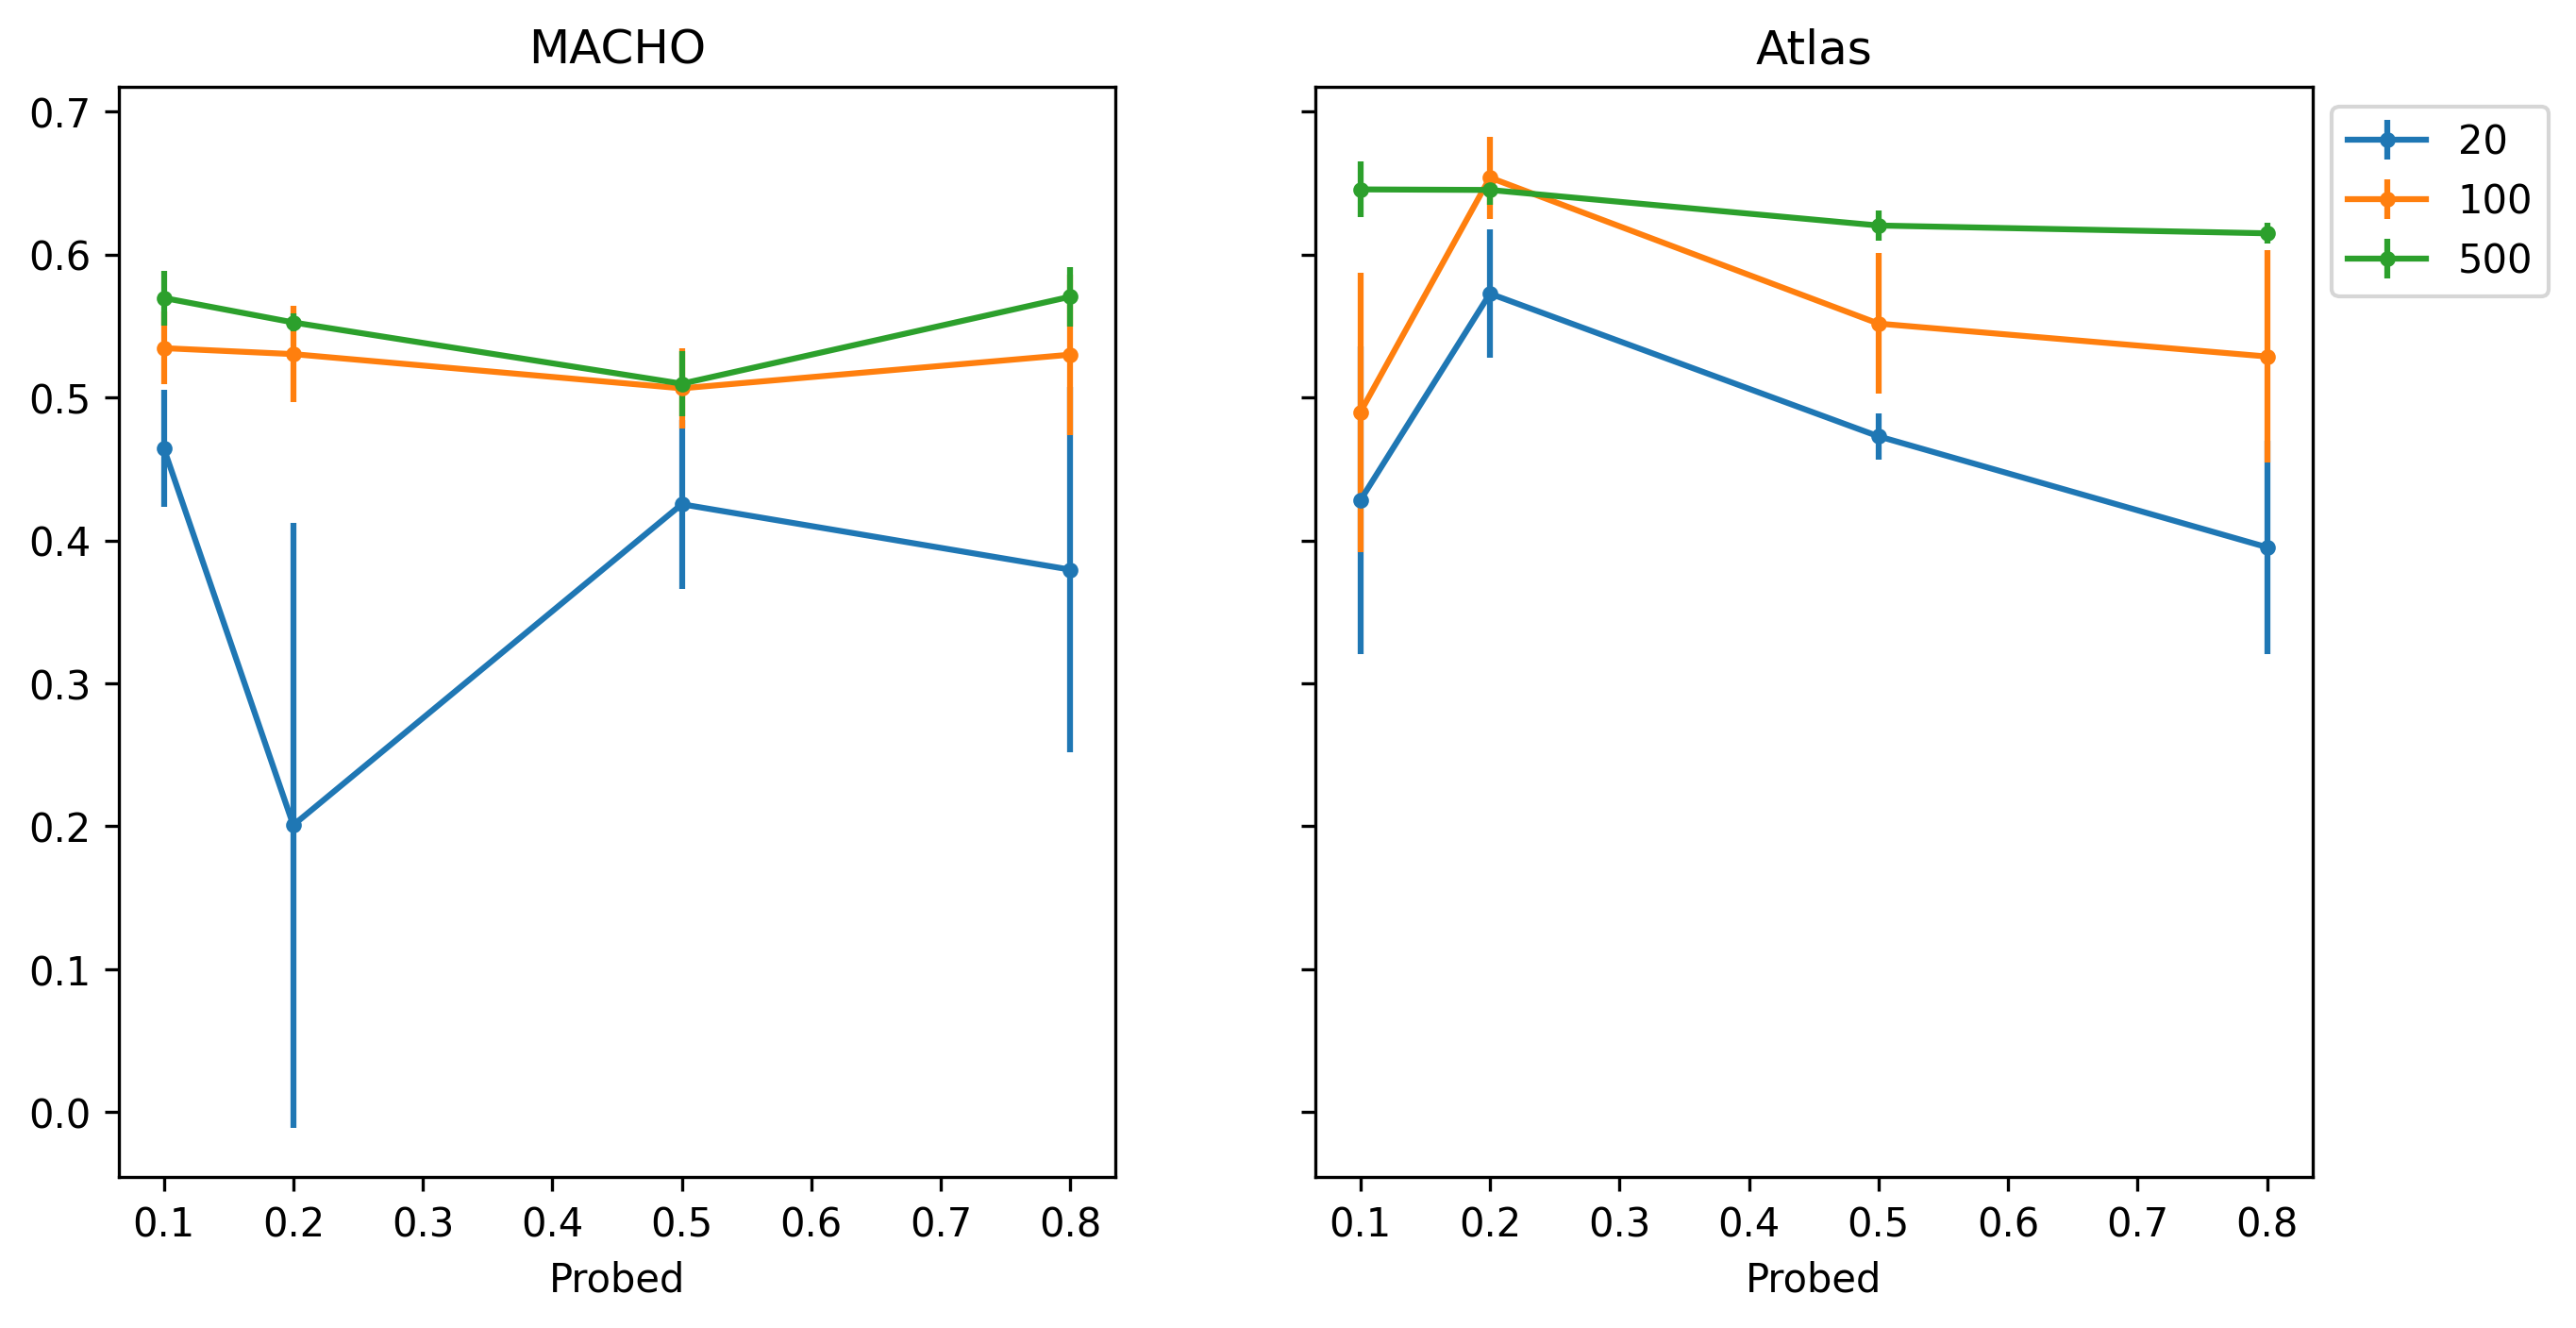

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), dpi=300, sharey=True)

for i, (dataset, frame) in enumerate(summary.groupby('dataset')):
    frame = frame.sort_values('probed')
    for spc, subframe in frame.groupby('spc'):
        
        axes[i].errorbar(subframe['probed'], subframe['clf_test_f1_x'], 
                     yerr=subframe['clf_test_f1_y'], marker='.', label=spc)
        
        axes[i].set_title(titles[dataset])
        axes[i].set_xlabel('Probed')
axes[-1].legend(bbox_to_anchor=(1., 1.0))

## H4: It is worth to add random noise during masked light curve modeling

In [33]:
selected_6 = selected_2[selected_2['model'].astype('str').str.contains('best')]
qformat02 = selected_2[(selected_2['model'].astype('str').str.contains('qformat_m0.5')) & ~(selected_2['model'].astype('str').str.contains('bugstromer'))]
selected_6 = pd.concat([selected_6, qformat02])

summary_mean = selected_6.groupby(['dataset', 'rs', 'spc'])['clf_test_f1'].mean().reset_index()
summary_std = selected_6.groupby(['dataset', 'rs', 'spc'])['clf_test_f1'].std().reset_index()
summary = pd.merge(summary_mean, summary_std, on=['rs', 'dataset', 'spc'])
summary['spc'] = summary['spc'].astype(int)

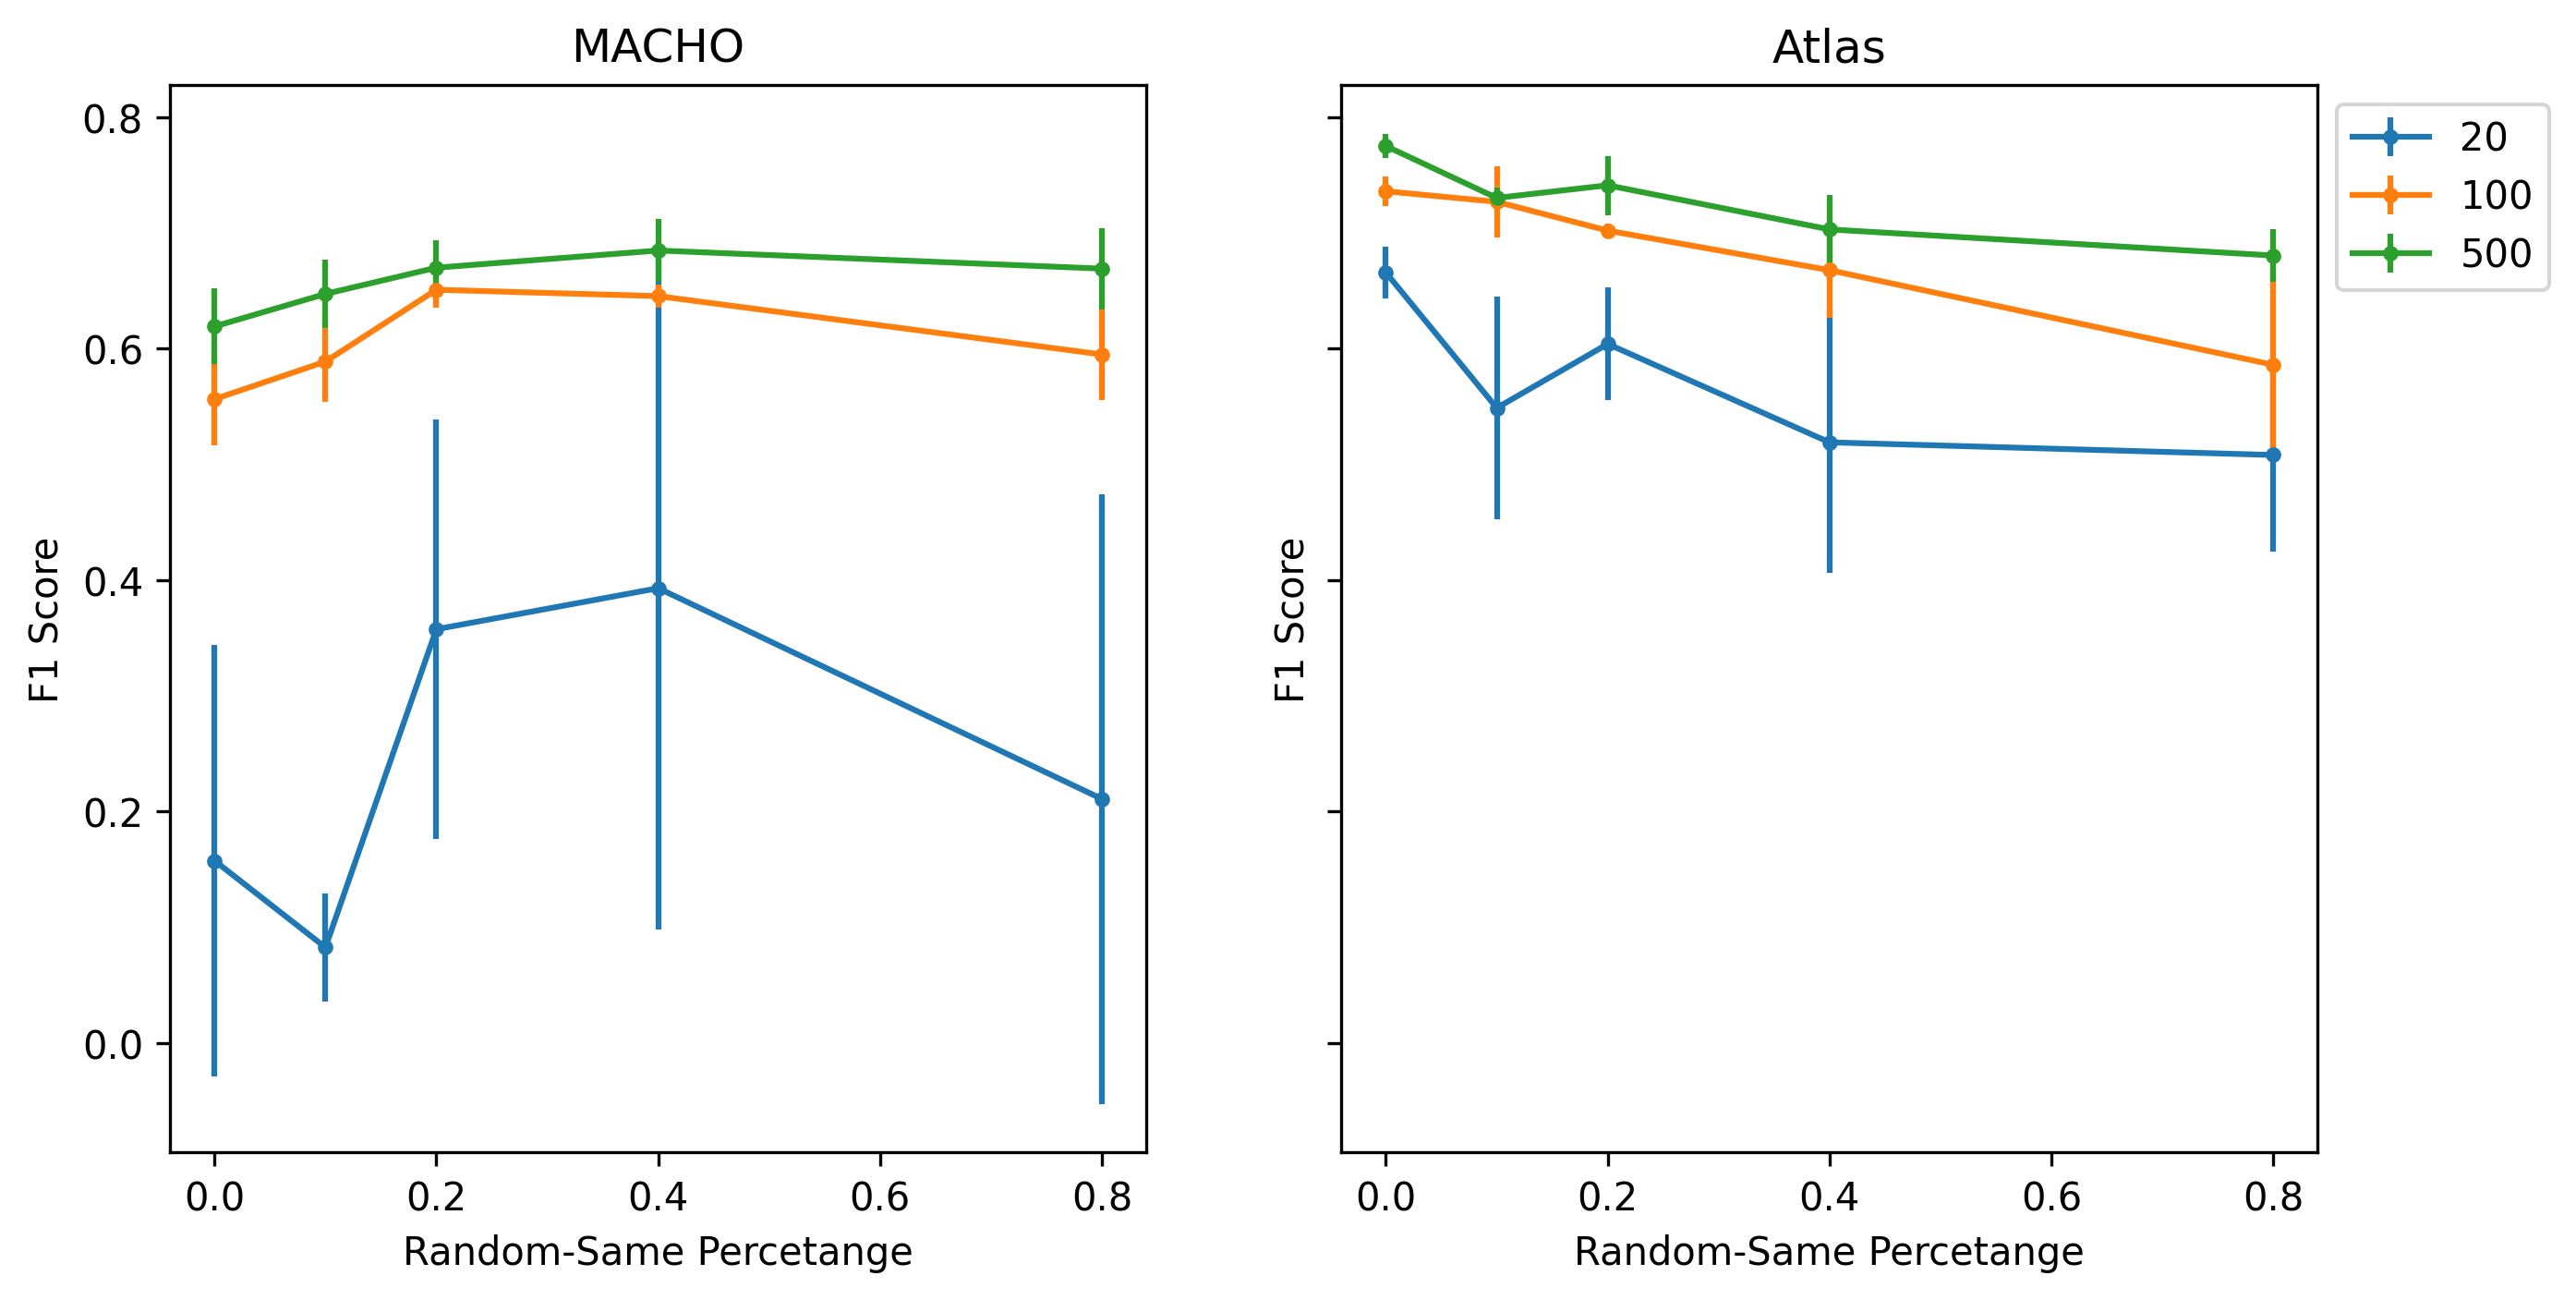

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), dpi=300, sharey=True)

for i, (dataset, frame) in enumerate(summary.groupby('dataset')):
    frame = frame.sort_values('rs')
    for spc, subframe in frame.groupby('spc'):
        
        axes[i].errorbar(subframe['rs'], subframe['clf_test_f1_x'], 
                     yerr=subframe['clf_test_f1_y'], marker='.', label=spc)
        
        axes[i].set_title(titles[dataset])
        axes[i].set_xlabel('Random-Same Percetange')
        axes[i].set_ylabel('F1 Score')
        
        
axes[-1].legend(bbox_to_anchor=(1., 1.0))


## Summary

In [44]:
summary_mean = selected_2.groupby(['dataset', 'model', 'probed','rs',  'm_alpha', 'spc'])['clf_test_f1'].mean().reset_index()
summary_std = selected_2.groupby(['dataset', 'model', 'probed', 'rs', 'm_alpha', 'spc'])['clf_test_f1'].std().reset_index()
summary = pd.merge(summary_mean, summary_std, on=['probed', 'rs', 'model', 'm_alpha', 'dataset', 'spc'])
summary['spc'] = summary['spc'].astype(int)
summary = summary.sort_values('clf_test_f1_x', ascending=True)


/tmp/ipykernel_275559/3624158594.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[count].set_yticklabels(frame['label'], rotation=0)
/tmp/ipykernel_275559/3624158594.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[count].set_yticklabels(frame['label'], rotation=0)


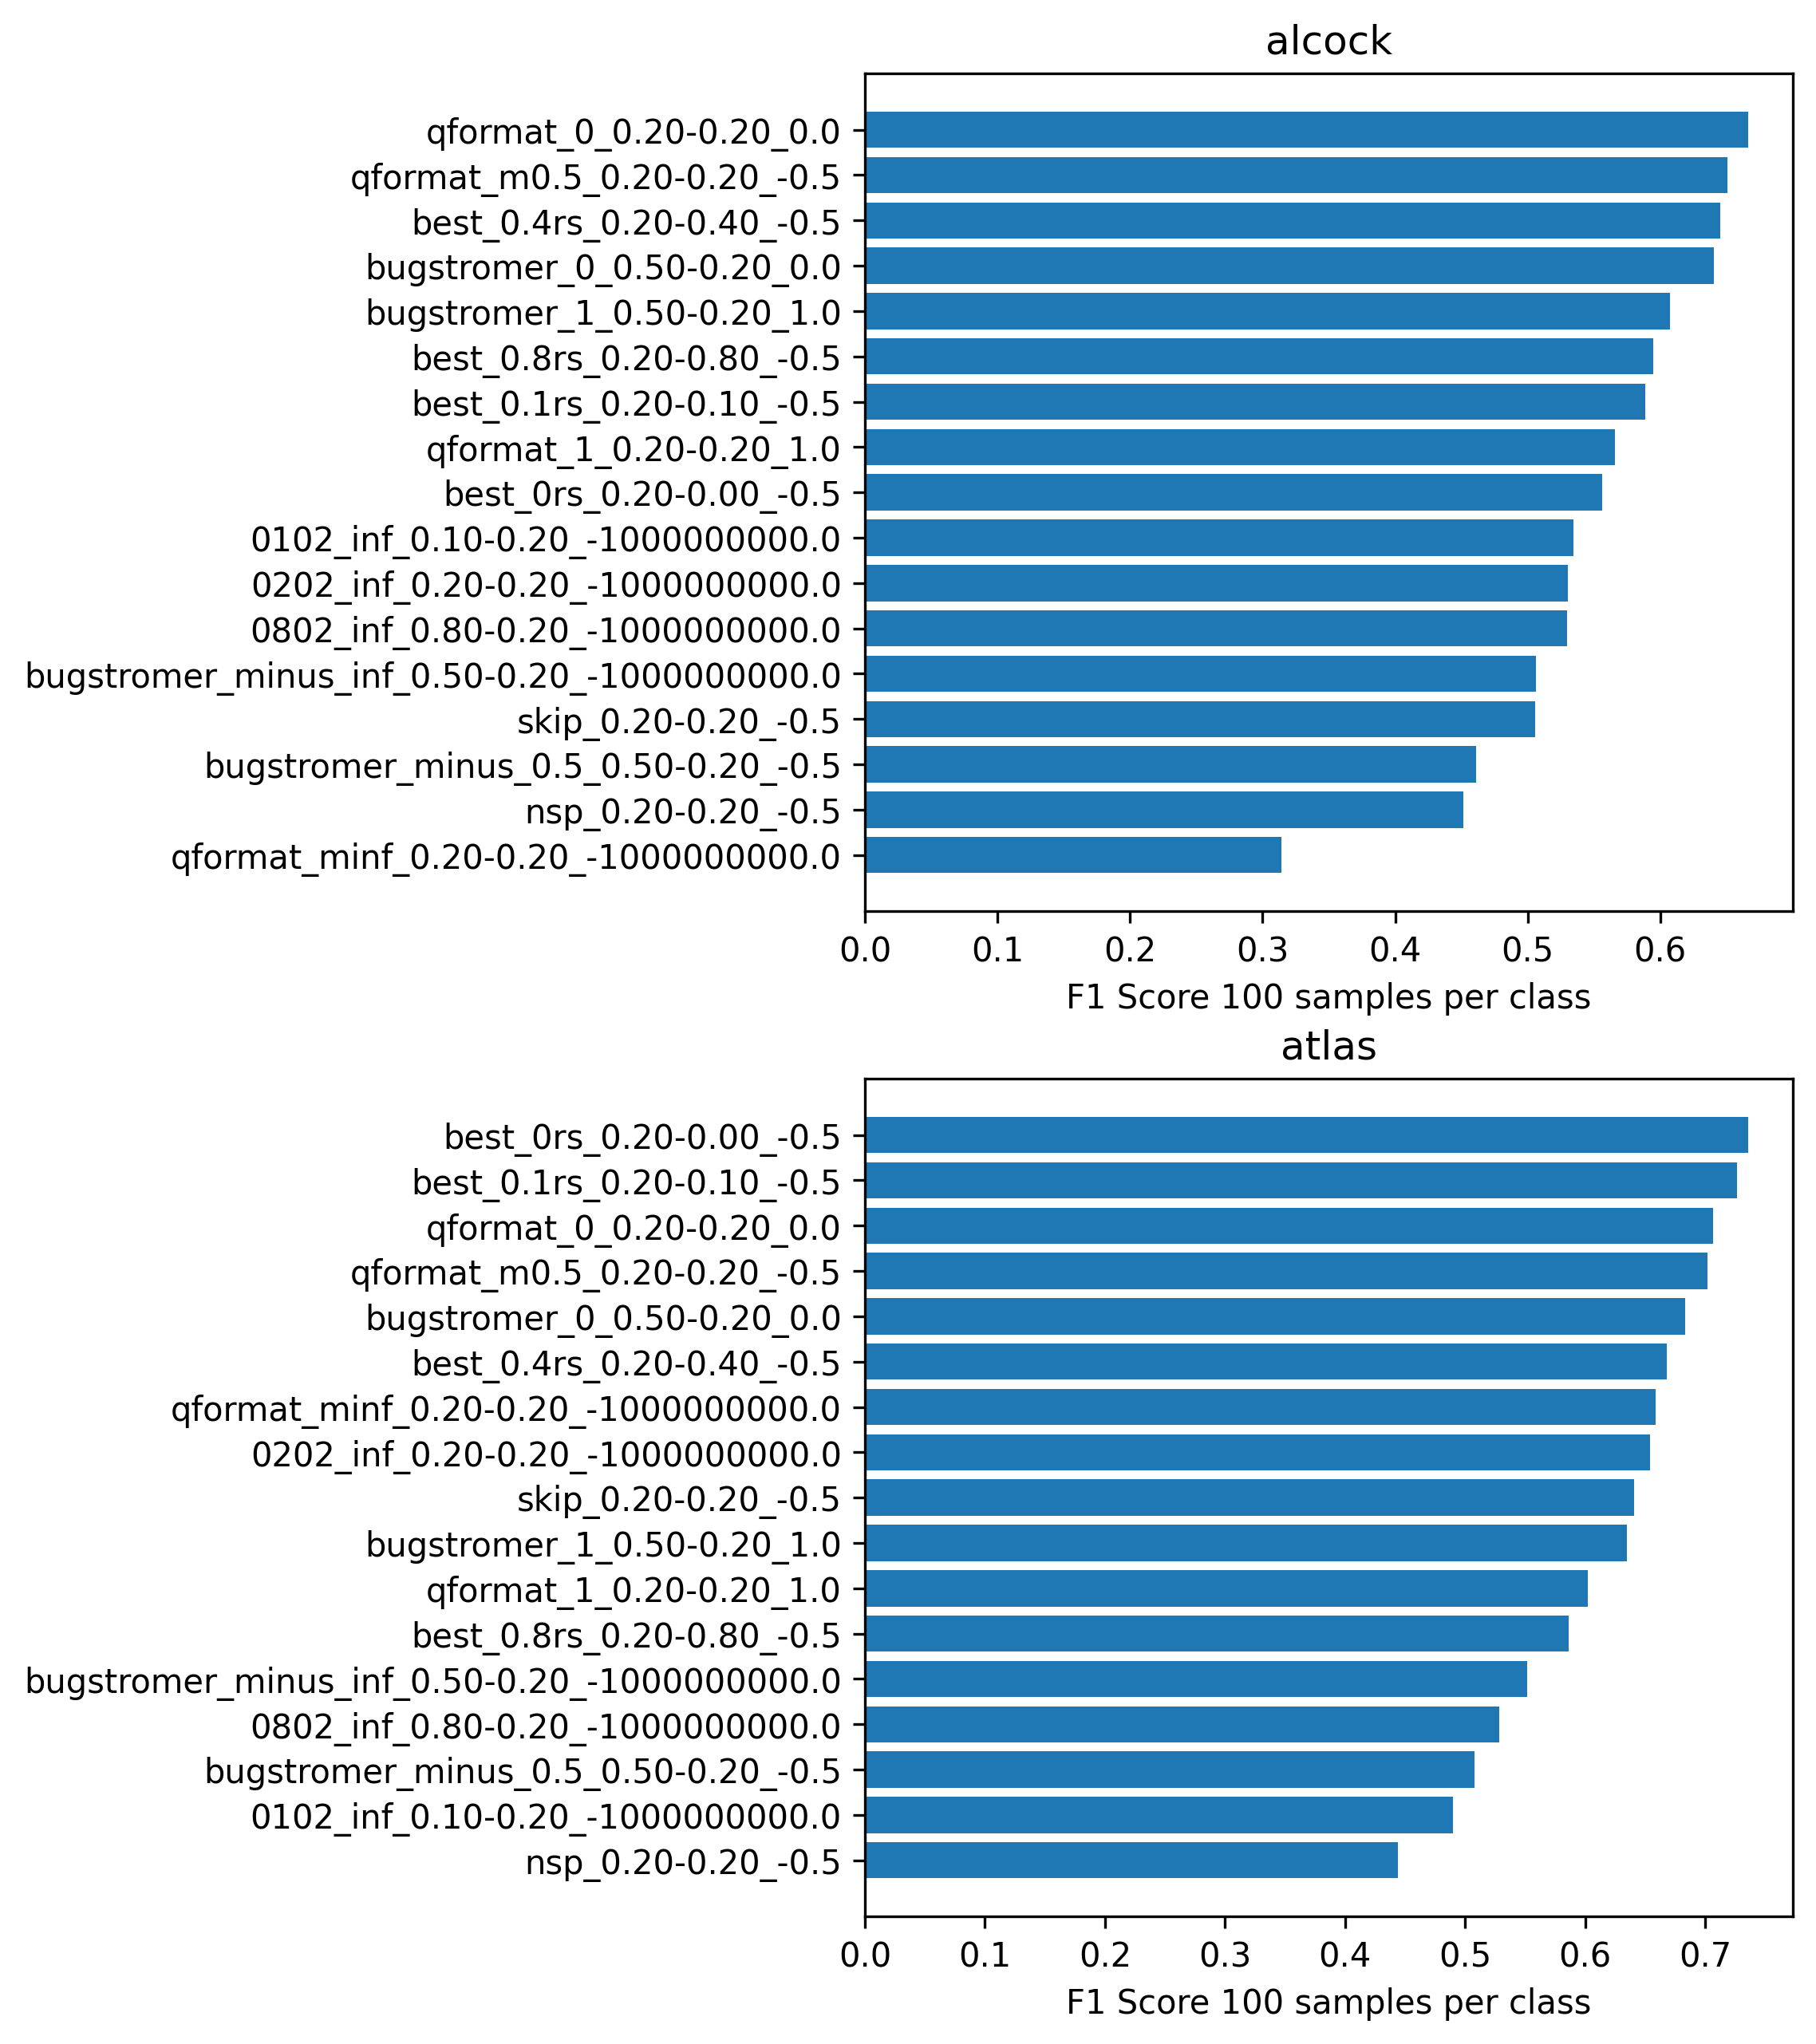

In [45]:
fig, axes = plt.subplots(2,1, figsize=(5, 10), dpi=300)

count = 0
for i, frame in summary[summary['spc'] == 100].groupby('dataset'):
    frame['label'] = frame.apply(lambda x: '{}_{:.2f}-{:.2f}_{}'.format(x['model'], 
                                                             x['probed'],
                                                             x['rs'],
                                                             x['m_alpha']), axis=1)
    
    axes[count].barh(frame['label'], frame['clf_test_f1_x'])
    axes[count].set_yticklabels(frame['label'], rotation=0)
    axes[count].set_title(i)
    axes[count].set_xlabel('F1 Score 100 samples per class')
    count+=1